In [5]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import requests
from io import BytesIO
from matplotlib import gridspec

from sklearn.metrics import pairwise_distances
from IPython.display import display, Image, SVG, Math, YouTubeVideo

In [6]:
clothes_data = pd.read_pickle("preprocessed_fashion_data_16k")

In [7]:
clothes_data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [8]:
clothes_data.shape

(16042, 7)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
bow_title_vectorizer = CountVectorizer()
bow_title_features = bow_title_vectorizer.fit_transform(clothes_data['title'])

In [11]:
bow_title_features.shape

(16042, 12609)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(clothes_data['title'])
tfidf_title_features.shape

(16042, 12609)

In [16]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [17]:
idf_title_vectorizer  = CountVectorizer()
idf_title_features = idf_title_vectorizer .fit_transform(clothes_data['title'])
idf_title_features.shape

(16042, 12609)

In [19]:
#vocab = stores all the words that are there in google w2v model
vocab = model.keys()
#this function will add the vectors of each word and returns the avg vector of given sentance

def build_avg_vec(sentence, num_features, doc_id, m_name):
    #sentace: its title of the apparel
    #num_features: the lenght of word2vec vector, its values = 300
    #m_name: model information it will take two values
        #if  m_name == 'avg', we will append the model[i], w2v representation of word i
        #if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features), dtype="float32")
    #we will intialize a vector of size 300 with all zeros
    #we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'idf_weighted' and word in idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
            elif m_name == 'tf_idf_weighted'and word in tfidf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[word]] * model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    #returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [20]:
doc_id = 0
avg_w2v_title = []
#for every title we build a avg vector representation
for i in clothes_data['title']:
    avg_w2v_title.append(build_avg_vec(i, 300, doc_id,'avg'))
    doc_id += 1

#avg_w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
avg_w2v_title = np.array(avg_w2v_title)
avg_w2v_title.shape

(16042, 300)

In [21]:
doc_id = 0
idf_w2v_title_weight = []
#for every title we build a weighted vector representation
for i in clothes_data['title']:
    idf_w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'idf_weighted'))
    doc_id += 1
#w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
idf_w2v_title_weight = np.array(idf_w2v_title_weight)
idf_w2v_title_weight.shape

(16042, 300)

In [22]:
#some of the brand values are empty. 
#need to replace Null with string "NULL"
clothes_data['brand'].fillna(value="Not Given", inplace=True)

#replace spaces with hypen
brands = [x.replace(" ", "-") for x in clothes_data['brand'].values]
colors = [x.replace(" ", "-") for x in clothes_data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

In [27]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

#load the features and corresponding ASINS info
bottleneck_features_train = np.load('IMAGE_features_CNN.npy')

asins = np.load('ASINS_features_for_16k.npy')

asins = list(asins)
df_asins = list(clothes_data['asin'])

In [28]:
def get_similar_products(title_technique, doc_id, wt, wb, wc, wi, num_results):
    doc_id = asins.index(df_asins[doc_id])
    
    title_dist  = pairwise_distances(title_technique, title_technique[doc_id].reshape(1,-1))
    brand_dist = pairwise_distances(brand_features, brand_features[doc_id])
    color_dist = pairwise_distances(color_features, color_features[doc_id])
    bottleneck_features_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    
    pairwise_dist = (wt * title_dist +  wb * brand_dist + wc * color_dist + wi * bottleneck_features_dist)/float(wt + wb + wc + wi)

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    
    for i in range(len(indices)):
        rows = clothes_data[['medium_image_url','title','brand','color']].loc[clothes_data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Brand:', row['brand'])
            print('Color:', row['color'])
            print('Euclidean Distance From The Query Image:', pdists[i])
            print('Amazon URL: www.amzon.com/dp/'+ asins[indices[i]])

In [ ]:
%pip install streamlit-option-menu

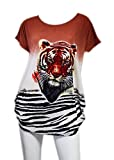

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Brand: Si Row
Color: Brown
Euclidean Distance From The Query Image: 3.4496715913216275e-06
Amazon URL: www.amzon.com/dp/B00JXQB5FQ


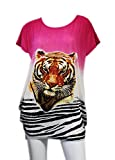

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Brand: Si Row
Color: Pink
Euclidean Distance From The Query Image: 16.95807681260898
Amazon URL: www.amzon.com/dp/B00JXQASS6


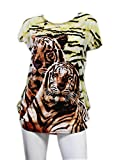

Product Title:  yellow tiger tshirt tiger stripes  l 
Brand: Si Row
Color: Yellow
Euclidean Distance From The Query Image: 22.787518878808765
Amazon URL: www.amzon.com/dp/B00JXQCUIC


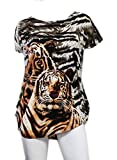

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Brand: Si Row
Color: Brown
Euclidean Distance From The Query Image: 24.128358339277394
Amazon URL: www.amzon.com/dp/B00JXQCWTO


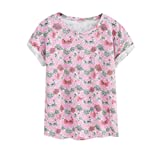

Product Title:  kawaii pastel tops tees pink flower design 
Brand: Namnoi Clothing Store
Color: As Show
Euclidean Distance From The Query Image: 26.120131982650587
Amazon URL: www.amzon.com/dp/B071FCWD97


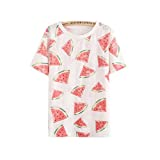

Product Title:  womens thin style tops tees pastel watermelon print 
Brand: Namnoi Clothing Store
Color: As show
Euclidean Distance From The Query Image: 26.16962557080502
Amazon URL: www.amzon.com/dp/B01JUNHBRM


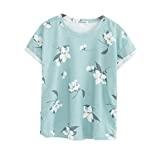

Product Title:  kawaii pastel tops tees baby blue flower design 
Brand: Namnoi Clothing Store
Color: As Show
Euclidean Distance From The Query Image: 26.219242935784152
Amazon URL: www.amzon.com/dp/B071SBCY9W


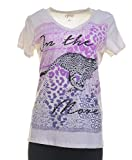

Product Title:  edv cheetah run purple multi xl 
Brand: Styleco
Color: White
Euclidean Distance From The Query Image: 26.382465447639824
Amazon URL: www.amzon.com/dp/B01CUPYBM0


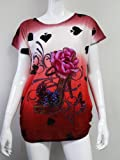

Product Title:  red  pink floral heel sleeveless shirt xl  xxl 
Brand: Si Row
Color: Red
Euclidean Distance From The Query Image: 26.408263100813976
Amazon URL: www.amzon.com/dp/B00JV63QQE


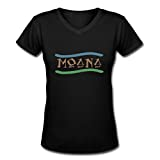

Product Title:  moana logo adults hot v neck shirt black xxl 
Brand: BOBOB
Color: Black
Euclidean Distance From The Query Image: 26.413662332019467
Amazon URL: www.amzon.com/dp/B01LX6H43D


In [29]:
get_similar_products(idf_w2v_title_weight, 12566, 10, 50, 10, 80, 10)